   # TP53: Effects of Missense/Truncating Mutations on Interacting Proteins - Visualization

<b>Standard imports for playing with and plotting data frames.</b>

In [240]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [241]:
import CPTAC

In [242]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [243]:
gene = 'TP53'
protList = ['TGFB1', 'AXIN1', 'EP300', 'HRMT1L2', 'CARM1', 'TAF1', 'ING4', 'CABLES1', 
            'TP73', 'HIPK1', 'HIPK2', 'TP53INP1', 'TP53BP', 'WWOX', 'HCV', 'USP7', 'SYVN1', 'HSP90AB1',
           'CHD8', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11', 'LKB1', 'UHRF2', 'E4F1', 'YWHAZ',
           'MAML1', 'MKRN1', 'PML', 'MDM2', 'FBXO42', 'ATM', 'PP2R2A', 'AURKA', 'DAXX', 'BRD7', 'TRIM24',
           'L3MBTL1', 'GRK5', 'CAK', 'PTK2B', 'PYK2', 'MDM2', 'PRKCG', 'PPIF', 'KAT6A', 'UBC9', 'ZNF385B',
           'ZNF385A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2', 'MORC3', 'POU4F2', 'AFG1L', 'UBD',
           'TAF6', 'HPV', 'UL123', 'E1B-55K', 'BAX', 'FAS', 'BCL2', 'CREBBP', 'CDK2', 'MDM2', 'CDKN2A', 'ATM',
            'CCNB1', 'TERT', 'IGF1R', 'ALB', 'MMP1', 'TP53']

## t-test for effects of missense and truncating mutations combined

In [244]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[(cross["Mutation"] == "Frame_Shift_Del") | 
                            (cross["Mutation"] == "Frame_Shift_Ins") |
                            (cross["Mutation"] == 'Nonsense_Mutation') |
                            (cross["Mutation"] == 'Missense_Mutation')]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [245]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [246]:
print(significant_proteins)
print(significant_pvals)

['TAF1' 'CABLES1' 'HSP90AB1' 'CHD8' 'CDKN2AIP' 'YWHAZ' 'AURKA' 'DAXX'
 'AFG1L' 'TAF6' 'FAS' 'CDK2' 'CDKN2A' 'CCNB1' 'TP53']
[3.18012864e-02 3.08937247e-04 2.85376930e-03 1.19816449e-04
 9.42028288e-03 1.61540643e-02 2.29023762e-03 2.23414917e-03
 2.82391663e-02 8.68648710e-03 2.75167754e-05 1.17675225e-02
 1.50004470e-03 2.29023762e-03 2.75167754e-05]


## Figures can easily be generated for each of these proteins and their phosphorylation sites by following the patterns below

## Plot all significant results (including p53 itself)

In [247]:
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]
#Append proteomic data for all the proteins to the dataframe with mutational information
for protein in significant_proteins:
    if (protein != gene):
        proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
        plotdf = plotdf.join(proteindf)
        
#Relabel the mutation types for plotting
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})

#Put all proteomic data into one column, with another column giving the protein name, and select for the mutations we want
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Proteomics')
plotdf = plotdf.loc[(plotdf['Mutation'] == 'Mutated') | (plotdf['Mutation'] == 'Control')]
plotdf = plotdf.dropna(axis=0)

### Code for generating figure

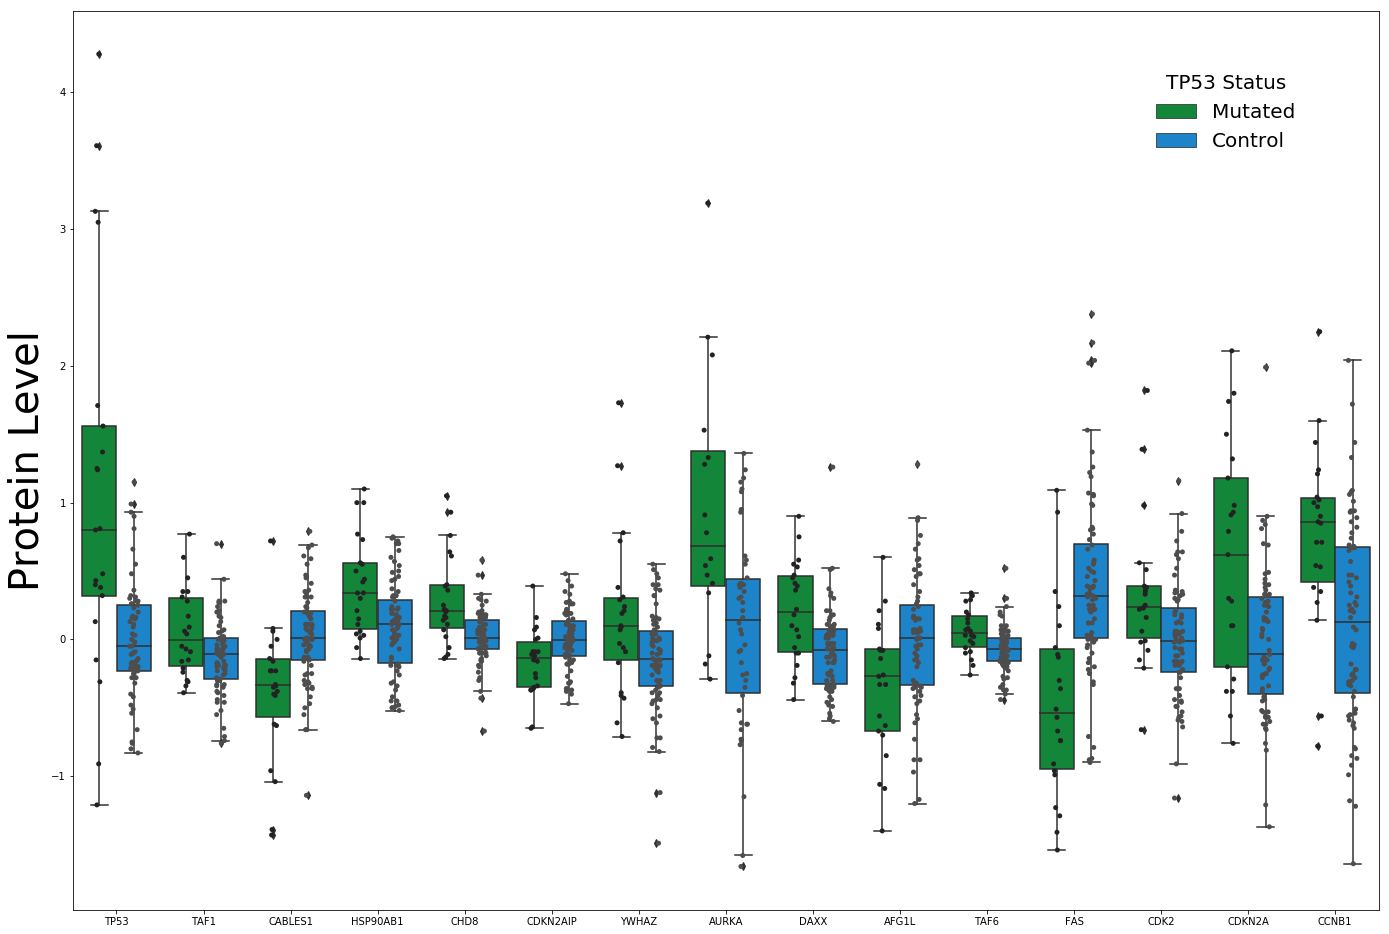

In [248]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='40')
boxplt.tick_params(labelsize='10')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.95, 0.95, 0, 0))

## TP53 Mutational Effects on p53

<b>Build dataframe for plotting</b>

In [249]:
proteomicsdf = CPTAC.compare_mutations(proteomics, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]

In [250]:
phosdf = CPTAC.compare_mutations(phos, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'][['TP53-S315']]

In [251]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], value_vars=['TP53', 'TP53-S315'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

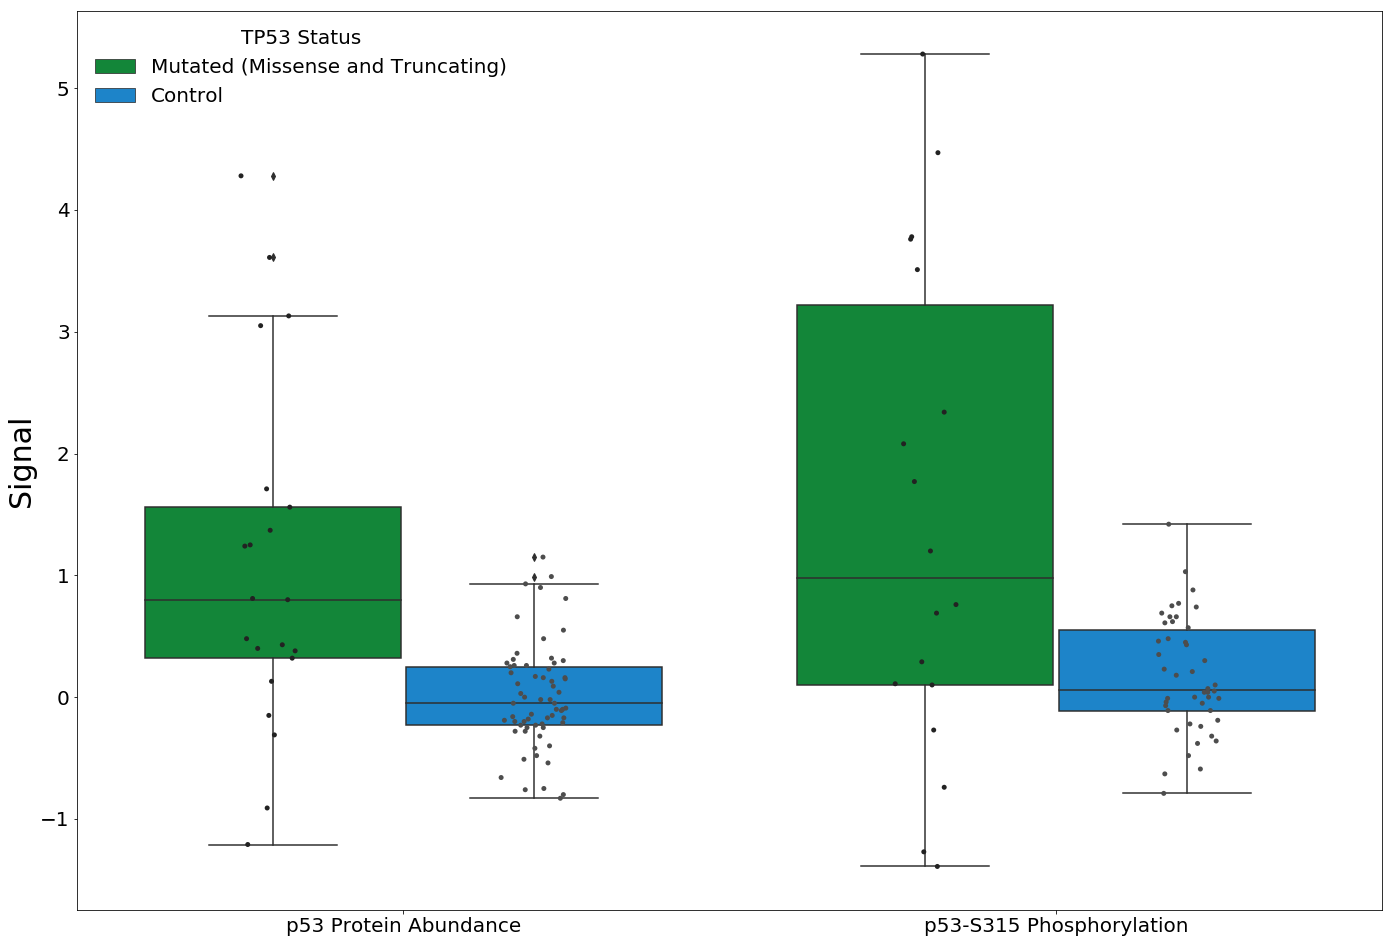

In [252]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CABLES1

### Retrieve the data and build dataframe for plotting

In [253]:
protein = 'CABLES1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [254]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [255]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

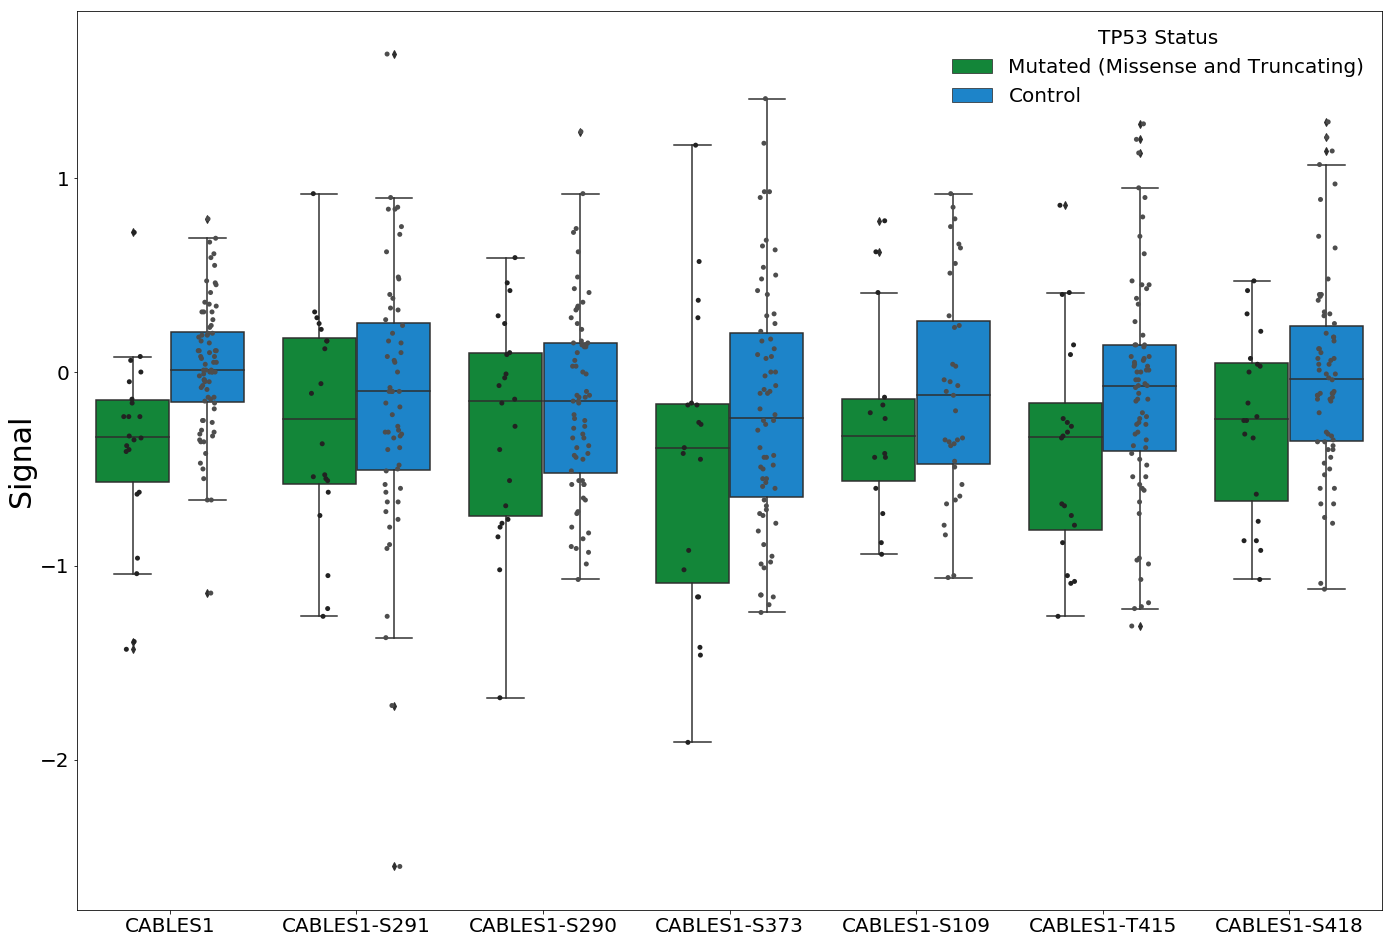

In [256]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and HSP90AB1

### Retrieve the data and build dataframe for plotting

In [257]:
protein = 'HSP90AB1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [258]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [259]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

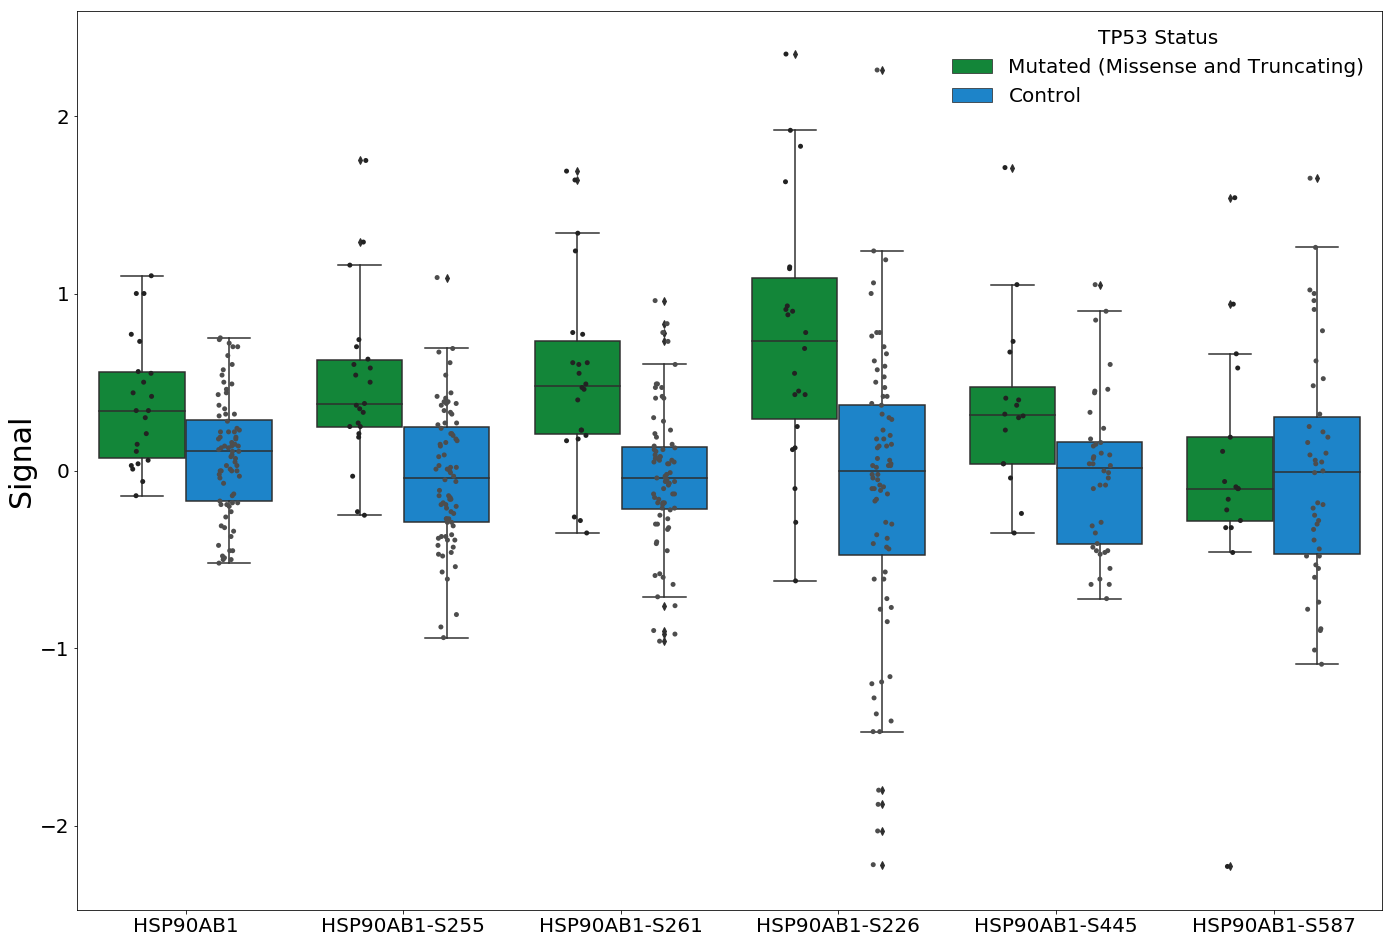

In [260]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

# TP53 and TAF1

### Retrieve the data and build dataframe for plotting

In [261]:
protein = 'TAF1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [262]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [263]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

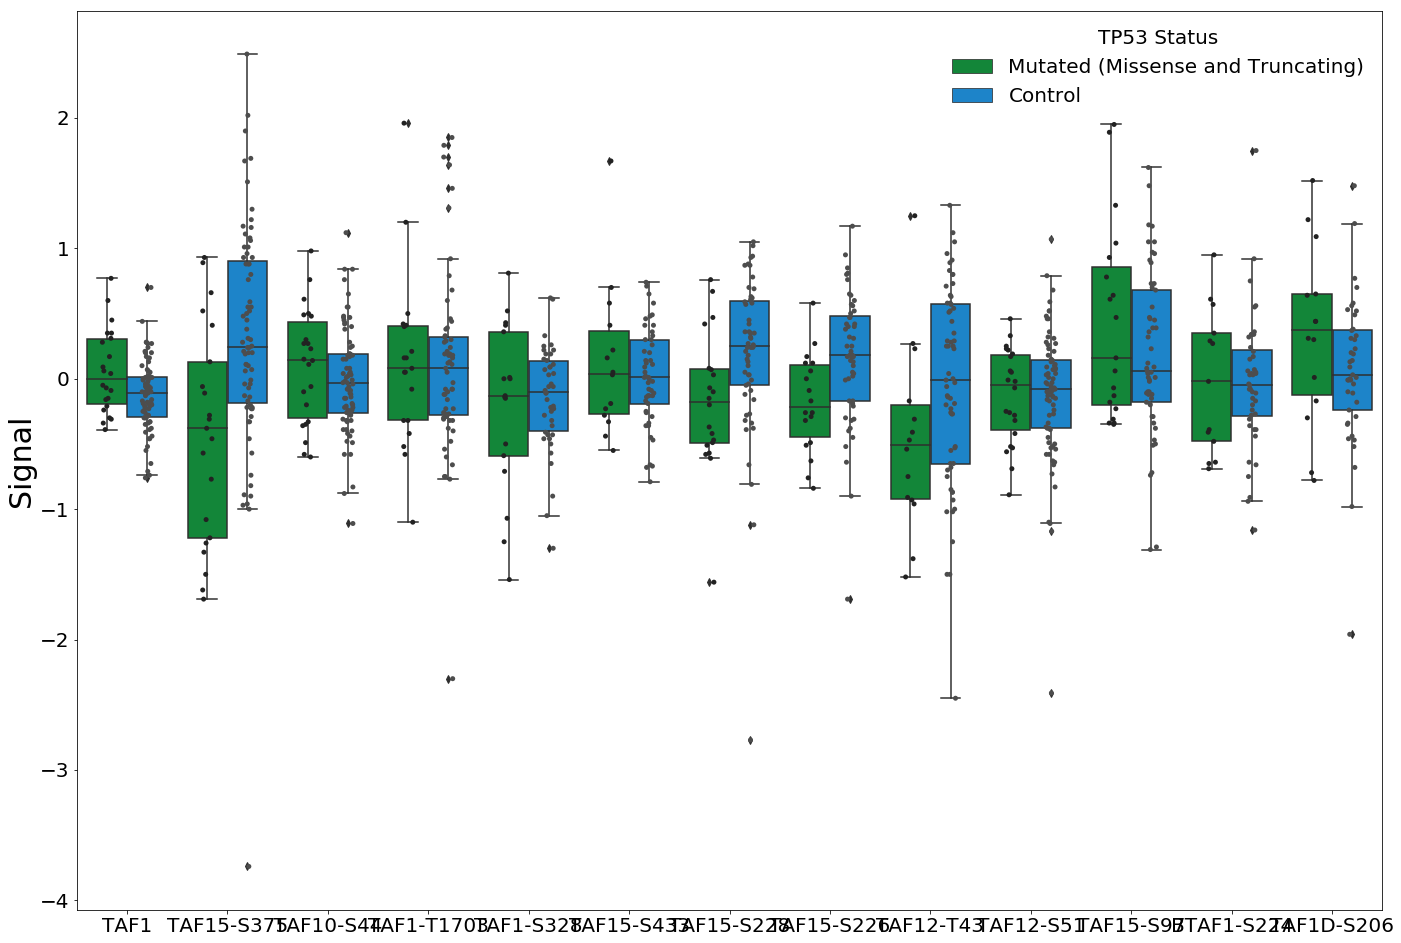

In [264]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CHD8

### Retrieve the data and build dataframe for plotting

In [265]:
protein = 'CHD8'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [266]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [267]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

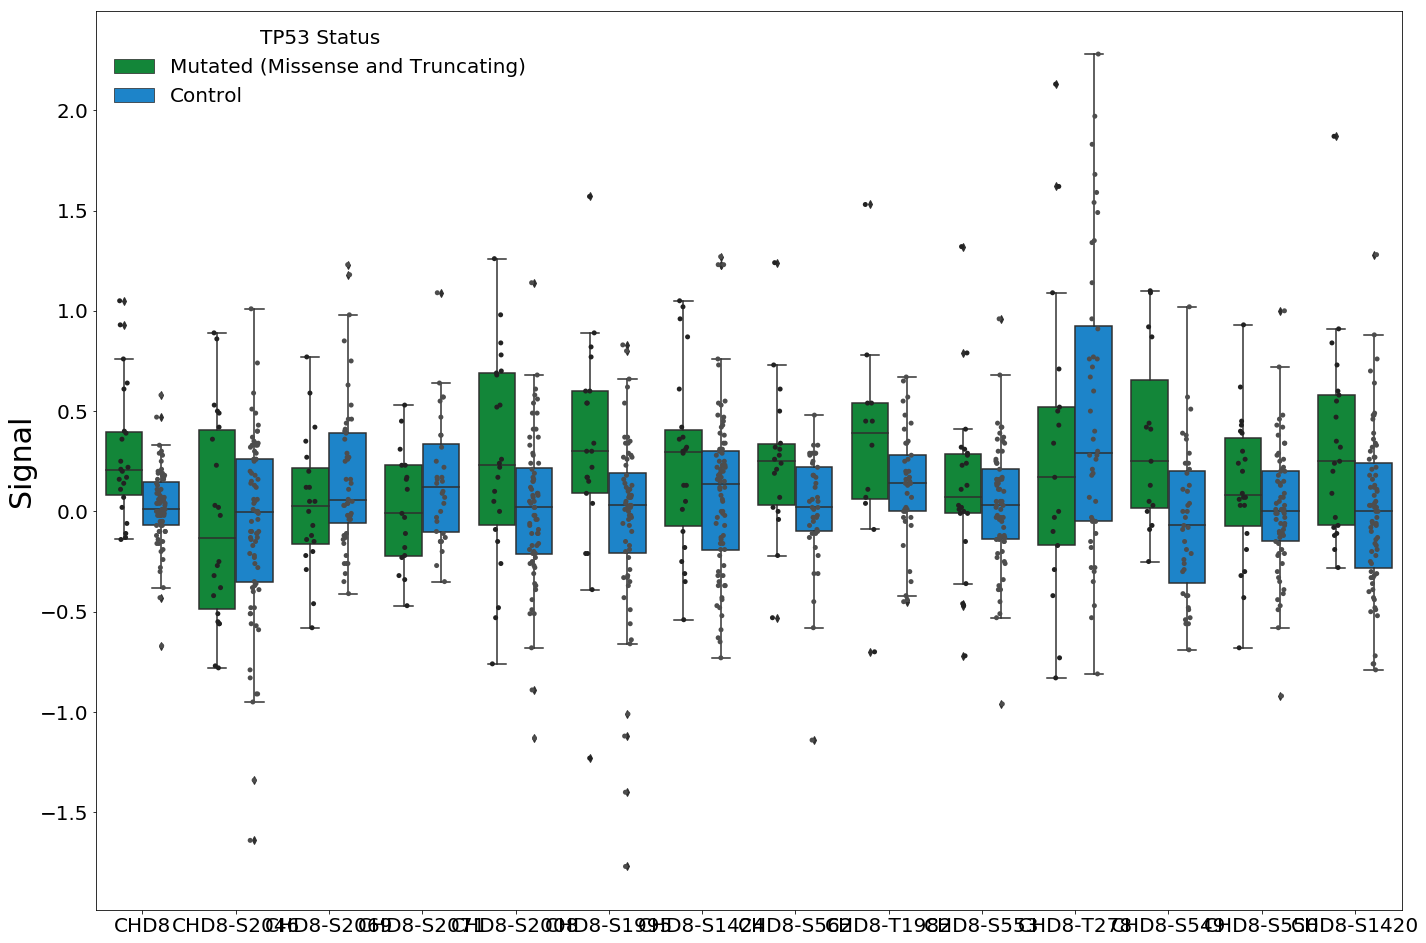

In [268]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CDKN2AIP

### Retrieve the data and build dataframe for plotting

In [269]:
protein = 'CDKN2AIP'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [270]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [271]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

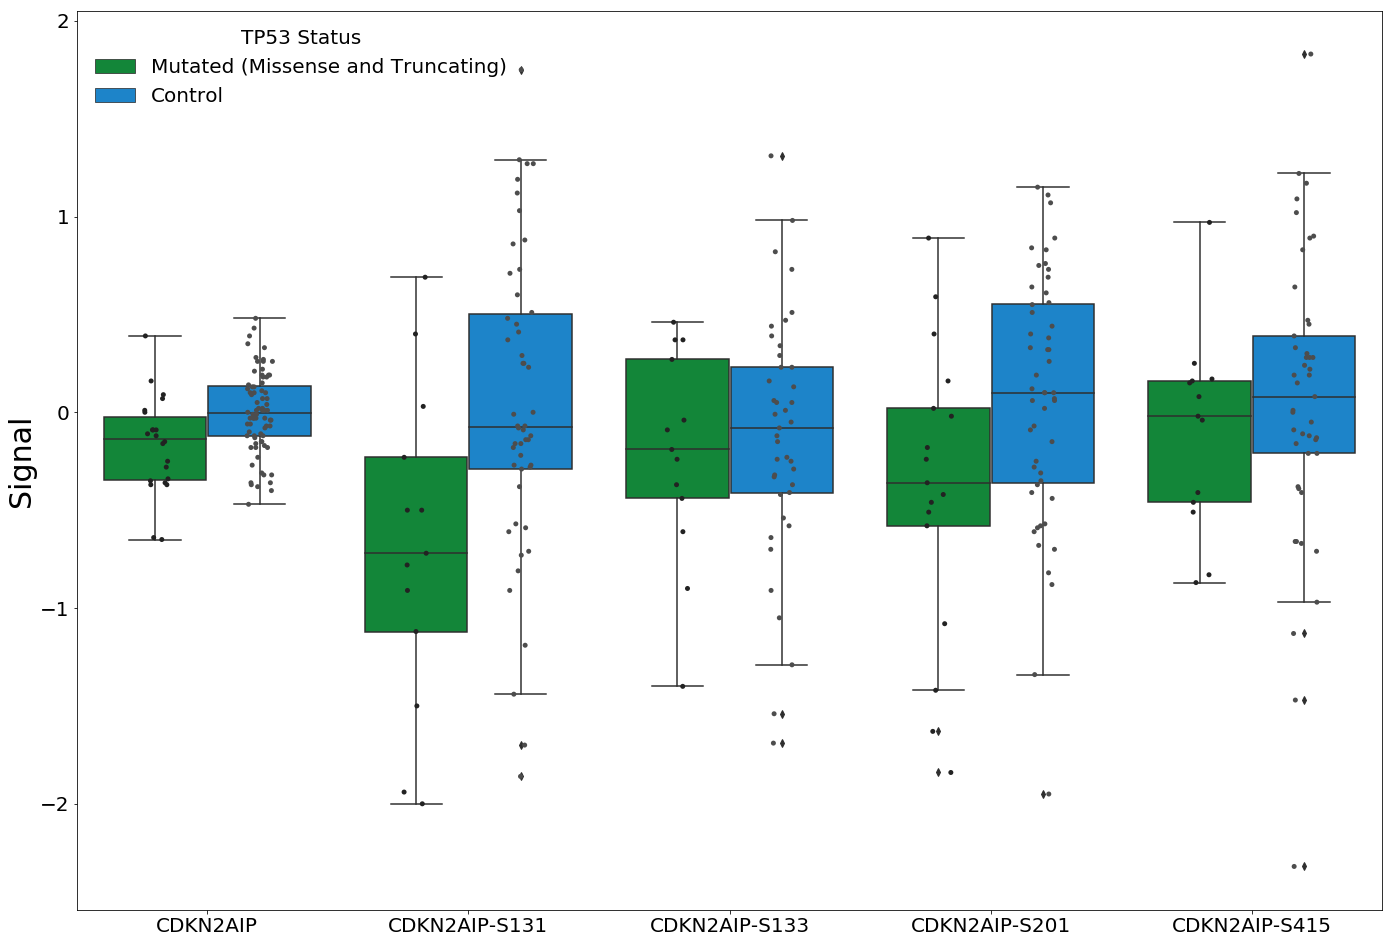

In [272]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and YWHAZ

### Retrieve the data and build dataframe for plotting

In [273]:
protein = 'YWHAZ'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [274]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [275]:
plotdf = proteomicsdf.join(phosdf)
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

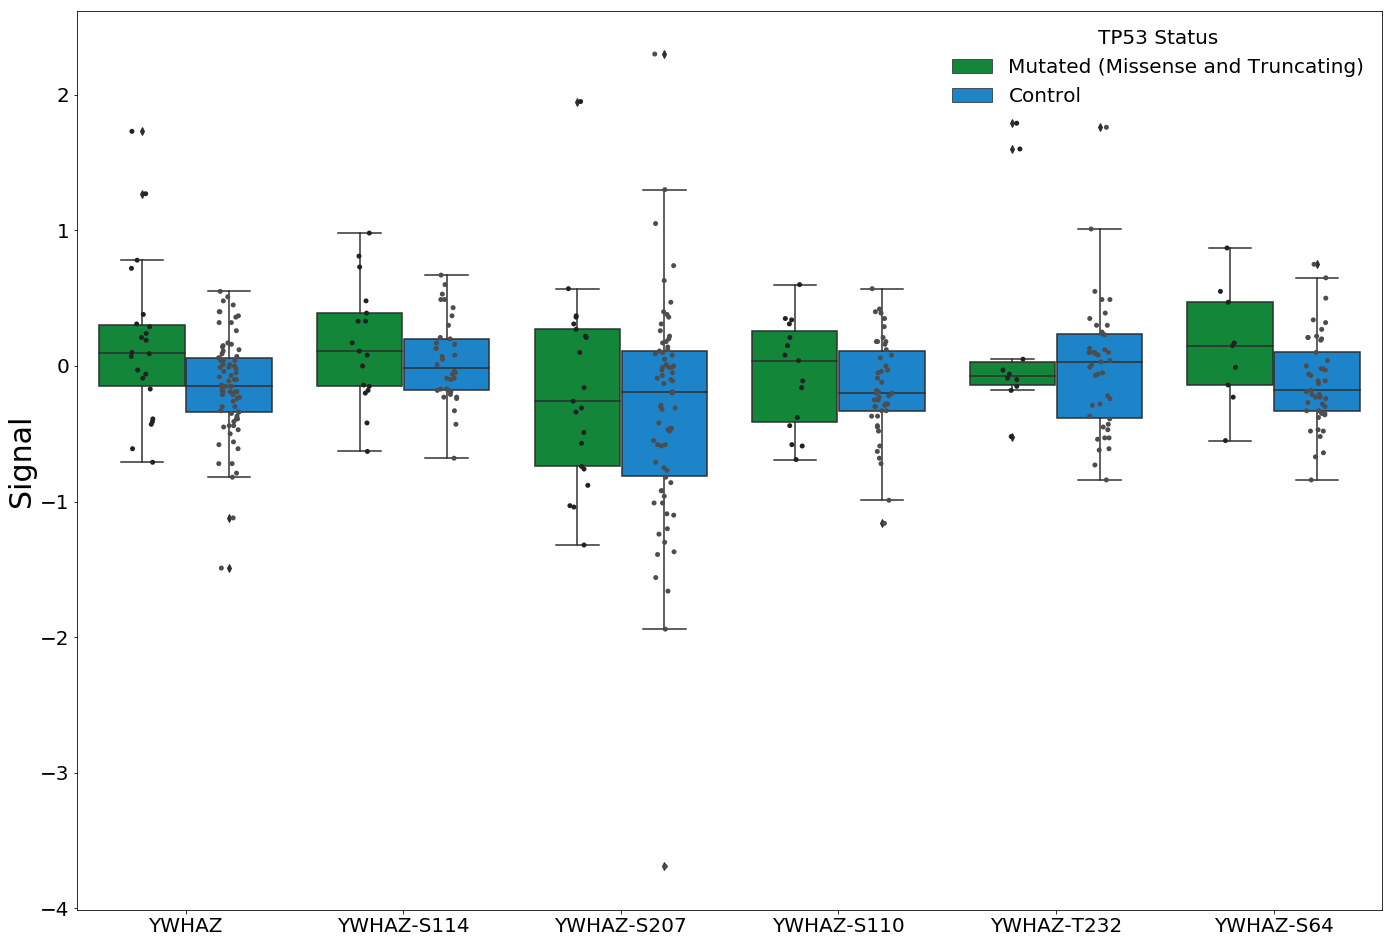

In [276]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and AURKA *no phosphoproteomics data

### Retrieve the data and build dataframe for plotting

In [277]:
protein = 'AURKA'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein, 'Mutation']]

In [278]:
plotdf = proteomicsdf.replace({'Mutation': {'Frame_Shift_Del': 'Mutated',
                                      'Frame_Shift_Ins': 'Mutated',
                                      'Nonsense_Mutation': 'Mutated',
                                      'Wildtype': 'Control',
                                      'Missense_Mutation': 'Mutated'}})
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

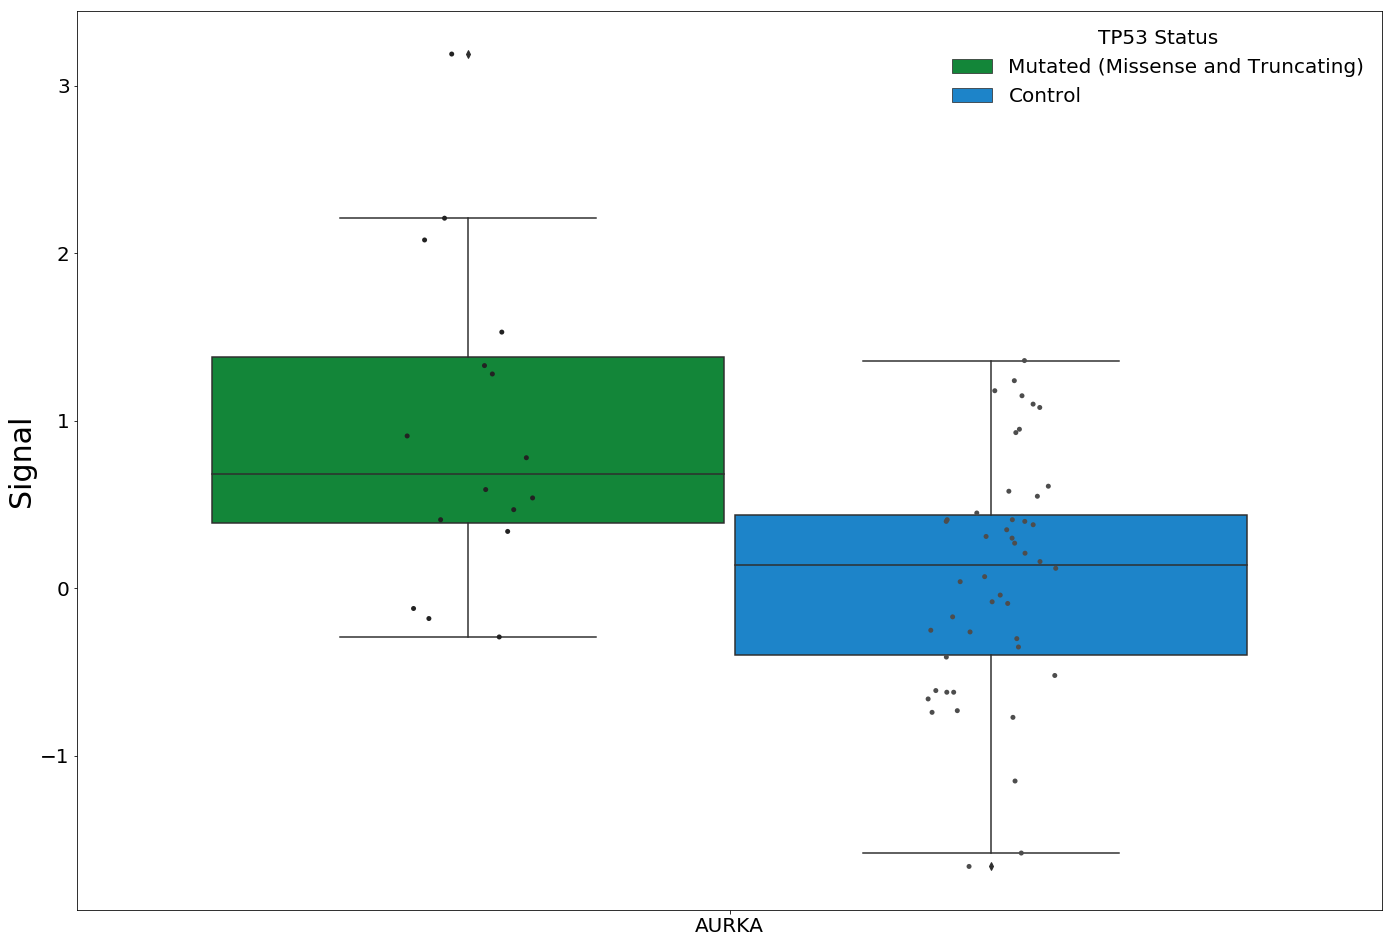

In [279]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated (Missense and Truncating)', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()